---
title: "logistic 2d"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

The figure below represents the distribution of height and weight for boys aged 10 and 13 years old.

In [2]:
#| code-summary: "import libraries"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

In [9]:
#| code-summary: "generate synthetic data"
def scipy_power_normal_draw_random(N, age, sex):   
    # Load LMS parameters from the CSV file
    df = pd.read_csv('../archive/data/weight/wtage.csv')
    agemos = age * 12 + 0.5
    df = df[(df['Agemos'] == agemos) & (df['Sex'] == sex)]
    L = df['L'].values[0]
    M = df['M'].values[0]
    S = df['S'].values[0]

    # draw random z from standard normal distribution
    z = np.random.normal(0, 1, N)
    # transform z to w
    w = M * (1 + L * S * z)**(1 / L)
    
    return w

# 10-year-old boys
N_10 = 120
w_10 = scipy_power_normal_draw_random(N_10, 10, 1)
df_height_boys = pd.read_csv('../archive/data/height/boys_height_stats.csv', index_col=0)
mu_boys_10 = df_height_boys.loc[10.0, 'mu']
sigma_boys_10 = df_height_boys.loc[10.0, 'sigma']
h_10 = norm.rvs(size=N_10, loc=mu_boys_10, scale=sigma_boys_10)

# 15-year-old boys
N_13 = 80
w_13 = scipy_power_normal_draw_random(N_13, 13, 1)
mu_boys_13 = df_height_boys.loc[13.0, 'mu']
sigma_boys_13 = df_height_boys.loc[13.0, 'sigma']
h_13 = norm.rvs(size=N_13, loc=mu_boys_13, scale=sigma_boys_13)

# Combine data into a single DataFrame
df = pd.DataFrame({
    'weight': np.concatenate([w_10, w_13]),
    'height': np.concatenate([h_10, h_13]),
    'age': [10] * N_10 + [13] * N_13
})

[Text(0.5, 0, 'weight (kg)'), Text(0, 0.5, 'height (cm)')]

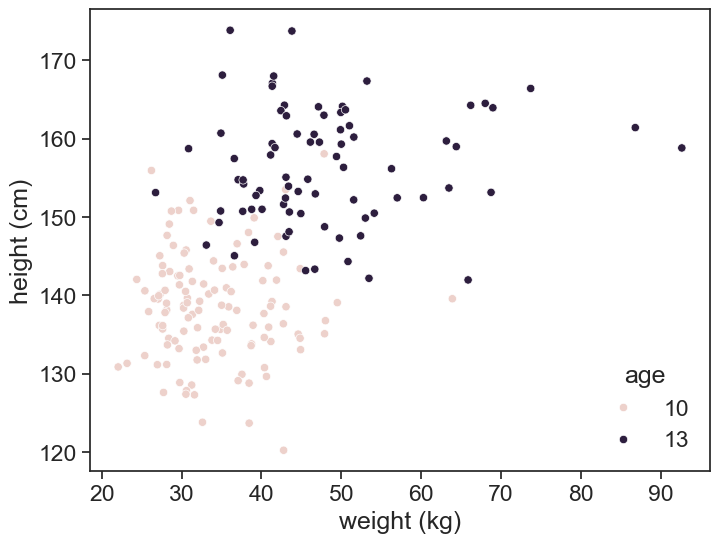

In [13]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=df, x='weight', y='height', hue='age', ax=ax)
ax.legend(title='age', loc='lower right', frameon=False)
ax.set(xlabel='weight (kg)',
       ylabel='height (cm)')

Our job is to find a decision boundary that separates the two classes. Fundamentally, this is the same as the logistic regression we saw in the previous chapter, but now we have two features instead of one. There are two ways to equivalent ways to describe this, the statisics and the machine learning way.

## statistics

We call our two features, height and weight, $x_1$ and $x_2$. We can write the logistic regression model as

$$
\log\left(\frac{p}{1-p}\right) = \beta_0 + \beta_1 x_1 + \beta_2 x_2
$$

where $p$ is the probability of being 13 years old. The left hand side is called the log-odds or logit. The right hand side is a linear combination of the features.

This is, of course, equivalent to the expression with the sigmoid function:

$$
p = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2)}}
$$

Speaking a "statistics language", this linear relationship is expressed by writing everything in matrix form:
$$
z = X\beta,
$$
where $X$ is the design matrix, $\beta$ is the vector of coefficients, and $z$ is the linear predictor. 

$$
\begin{pmatrix} z_1 \\ z_2 \\ \vdots \\ z_n \end{pmatrix} = \begin{pmatrix} 1 & x_{11} & x_{12} \\ 1 & x_{21} & x_{22} \\ \vdots & \vdots & \vdots \\ 1 & x_{n1} & x_{n2} \end{pmatrix} \begin{pmatrix} \beta_0 \\ \beta_1 \\ \beta_2 \end{pmatrix} = \begin{pmatrix} \beta_0 + \beta_1x_{11} + \beta_2x_{12} \\ \beta_0 + \beta_1x_{21} + \beta_2x_{22} \\ \vdots \\ \beta_0 + \beta_1x_{n1} + \beta_2x_{n2} \end{pmatrix}
$$

## machine learning

In machine learning, we often call the intercept term the bias, and we call the coefficients weights. We can write the linear predictor as
$$
z = w_1 x_1 + w_2 x_2 + b
$$
where $w_1$ and $w_2$ are the weights, and $b$ is the bias. In matrix form:
$$
z = w^T x + b,
$$
which expands to
$$
\begin{pmatrix} z_1 \\ z_2 \\ \vdots \\ z_n \end{pmatrix} = \begin{pmatrix} w_1 & w_2 \end{pmatrix} \begin{pmatrix} x_{11} & x_{12} \\ x_{21} & x_{22} \\ \vdots & \vdots \\ x_{n1} & x_{n2} \end{pmatrix} + \begin{pmatrix} b \\ b \\ \vdots \\ b \end{pmatrix} = \begin{pmatrix} w_1x_{11} + w_2x_{12} + b \\ w_1x_{21} + w_2x_{22} + b \\ \vdots \\ w_1x_{n1} + w_2x_{n2} + b \end{pmatrix}
$$

This is the same as the statistics formulation, just with different names for the parameters.

## solving

I boy from either 7th grade (13 years old) or 5th grade (10 years old) is randomly selected. Given his height (150 cm) and weight (45 kg), we want to predict his age group.

Predicted probability of being 13 years old: 0.848


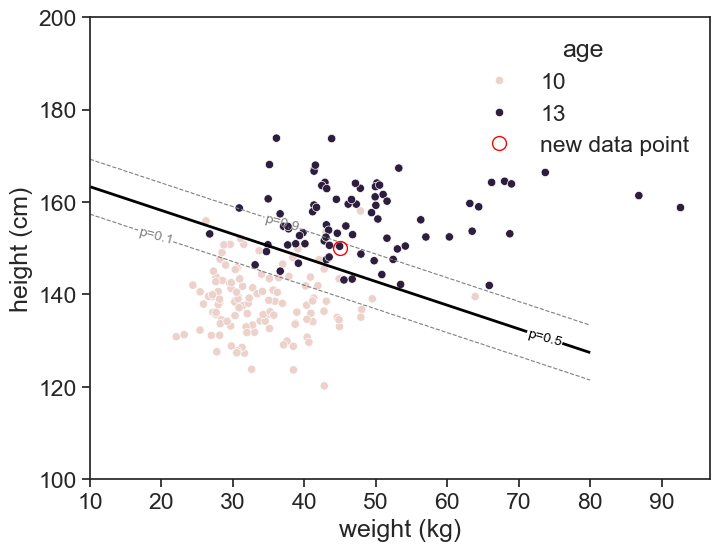

In [64]:
#| code-summary: "finding the decision boundary"
fig, ax = plt.subplots(figsize=(8, 6))
X = df[['weight', 'height']]
y = df['age']
model = LogisticRegression()
model.fit(X, y)
xx, yy = np.meshgrid(np.linspace(10, 80, 100), np.linspace(100, 200, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]
predict_df = pd.DataFrame(grid_points, columns=['weight', 'height'])
Z = model.predict(predict_df)
Z = Z.reshape(xx.shape)
Z_prob = model.predict_proba(predict_df)[:, 1]
Z = Z_prob.reshape(xx.shape)
# contour_fill = ax.contourf(xx, yy, Z, levels=np.arange(0, 1.1, 0.2), cmap='RdBu_r', alpha=0.8)
cont = ax.contour(xx, yy, Z, levels=[0.1, 0.5, 0.9], colors=['gray', 'black', 'gray'], linestyles=['--', '-', '--'], linewidths=[0.8, 2, 0.8])
ax.clabel(cont, fmt='p=%1.1f', inline=True, fontsize=10)

sns.scatterplot(data=df, x='weight', y='height', hue='age', ax=ax)
ax.set(xlabel='weight (kg)',
       ylabel='height (cm)');

h1 = 150
w1 = 45
df1 = pd.DataFrame([[w1, h1]], columns=['weight', 'height'])
ax.plot([w1], [h1], ls='None', marker='o', markersize=10, markerfacecolor='None', markeredgecolor='red', label="new data point")
ax.legend(title='age', loc='upper right', frameon=False)
p1 = model.predict_proba(df1)[0, 1]
print(f"Predicted probability of being 13 years old: {p1:.3f}")

The thick line in the figure above is the decision boundary, where the probability of being 13 years old is 0.5. The equation of the line is

$$
0 =  w_1 x_1 + w_2 x_2 + b,
$$

were feature $x_1$ is weight and feature $x_2$ is height. The weights $w_1,w_2$ and bias $b$ are

In [65]:
#| code-fold: false
model.coef_, model.intercept_

(array([[0.19047627, 0.37131303]]), array([-62.54777199]))